<H1> Job postings analysis </H1>

In this notebook we analyze the text from a number of job postings in the Business Intelligence and Analytics areas. 
What we are trying to identify are the tools in demand, the frequency they appear in job postings as well as the co-occurence of tools/platforms. eg. what are the "clusters" of tools requested by employers for a job type?

In this exercise, a sample of 81 job postings was analyzed. The source of these postings was linkedin. The posting dates of the jobs were between 2019 and 2020.


In [101]:
#if needed install corpustools package
#install.packages("corpustools")

In [116]:
#Load library
library(corpustools)
library(ggplot2) 
library(quanteda)

Our main data include the following information:
- JobID: A numeric index of the vacancy
- Title: The job title
- Requirements: The job description
- Company: The company name
- Date: Job posting date
- Country: The country where the posting refers to
- Source: The source of the job posting (eg. linkedin, indeed)
- Search Terms: The search terms used to retrieve the job posting (eg. Business Intelligence, Analytics)

Two auxiliary reference files are also used in this example.

Tools List file. A file with software tools/platforms/technologies, which will serve as a reference to identify tools in demand
Tools dictionary. A mapping file, in the form of a dictionary, that "translates" tool phrasing variations into one common title. Eg. "BO" and "Business Objects" are mapped to "Business Objects", "Qlik Sense" and "Qliksense" are mapped to "Qliksense" etc.

In [117]:
#get vacancies data
VACANCIES <- read.csv("data/samples/mine/VACANCIES.csv", comment.char="#")

In [118]:
VACANCIES$newdt<-as.POSIXct(VACANCIES$DATE_TXT)

In [119]:
#create a list of tools, frorm an external file
tools_list <- scan("data/samples/mine/tools.txt", what="", sep="\n",skip = 1)

#create a "mapping" tools dictionary
tools_dict <- read.delim("data/samples/mine/tools_dict.txt")

In [120]:
#create corpus for vacancies
tc = create_tcorpus(VACANCIES, doc_column = 'JOBID', text_columns = 'REQUIREMENTS')

In [121]:
#remove duplicate job ads, keep only latest one based on date
tc$deduplicate(feature='token', date_col = 'newdt', similarity = 0.75, keep = 'last')
#tc$meta$doc_id


Deleting 0 duplicates


In [122]:
#basic preprocessing

# The basic preprocessing techniques can be performed on a tcorpus with the preprocess method. The main arguments are:
#   
# column: the name of the column to use as input. Default is “token”
# new_column: the name of the column in which to store the output. Default is “feature”
# lowercase: make text lowercase. Defaults to TRUE
# remove_punctuation: remove punctuation. Defaults to TRUE
# use_stemming: apply stemming. Defaults to FALSE
# remove_stopwords: removes stopwords (e.g., the, it, is). Defaults to FALSE
# language: the language used for stemming and stopword removal. Defaults to “english”

tc$preprocess( remove_stopwords=T, remove_numbers = T, ngrams=1, ngram_context = 'document', min_freq = 1)

#map terms according to dictionary file
tc$replace_dictionary(tools_dict, string_col='string',token_col='feature',code_col='code',sep=" ",verbose=T)

Preparing features
Preparing dictionary
Coding features


In [123]:
#"tag" tokens as tools, if found within the tools list.
tools_df<-as.data.frame(tools_list)
colnames(tools_df)<-c("string")
tc$code_dictionary(tools_df,token_col = 'token', string_col = 'string',flatten_colloc=T, sep=" ",verbose=T)



Preparing features
Preparing dictionary
Coding features


After creating and processing our corpus, we create a "semantic network" of the terms that we have found in the job postings.

We calculate the co-occurence of features and draw a network/graph in the igraph format,
where nodes are  <b>tokens</b> and edges represent the <b>similarity/adjacency</b> of tokens. Co-occurence
is calcuated based on how often two tokens co-occurr within a given token distance.

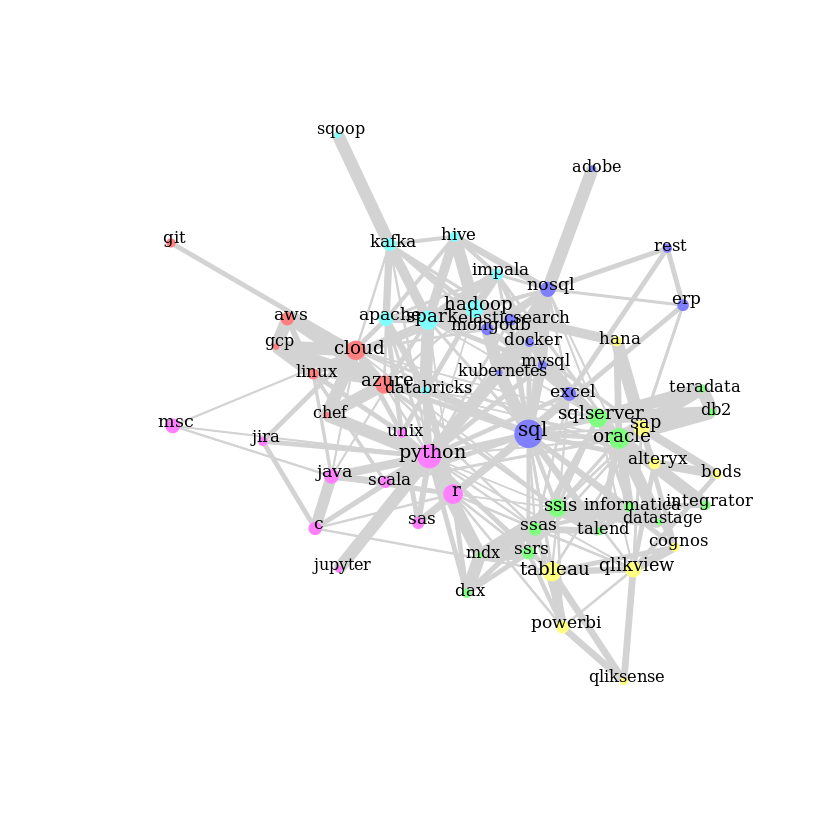

In [124]:
g = semnet_window(subset(tc,!is.na(code_id)),'feature')
plot_semnet(g)

A different approach is to extract the <b>backbone</b> of the network. 

Used cutoff edge-weight 0.0613983497495279 to keep number of vertices under 50
(For the edges the original weight is still used)


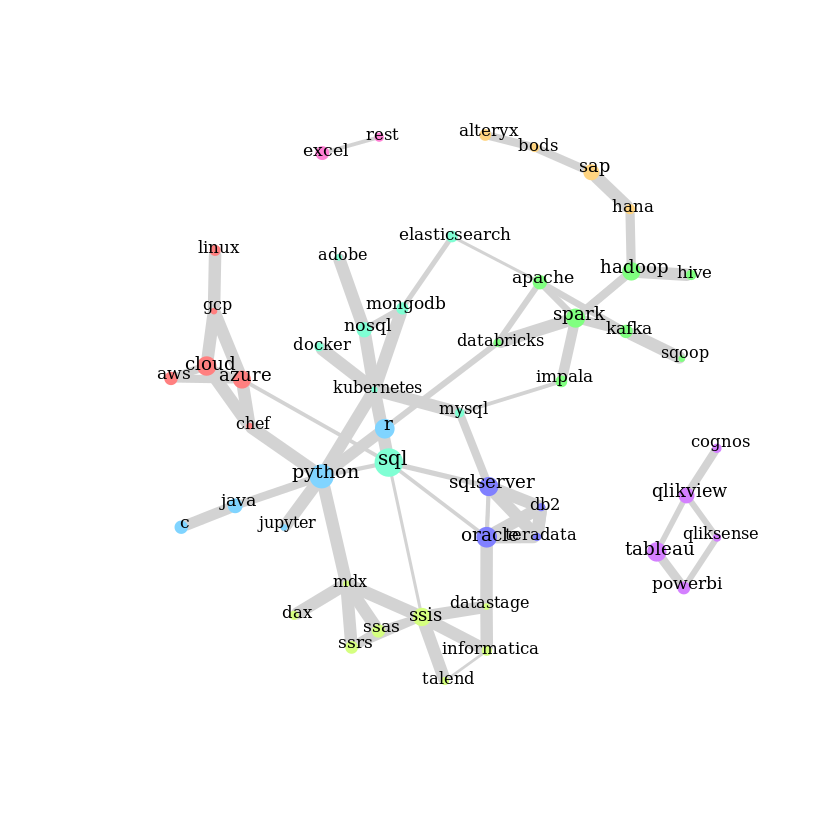

In [125]:
gb = backbone_filter(g, alpha = 0.1, max_vertices =50)
plot_semnet(gb)

A third way to visualize the term connections is by using the similarity measure. In the graph output we can see that the:

- node size denotes  the relative term frequency
- color denotes clusters of terms that frequenty appear together
- edges denote cooccurence of terms
- distance denotes the magnitude of association


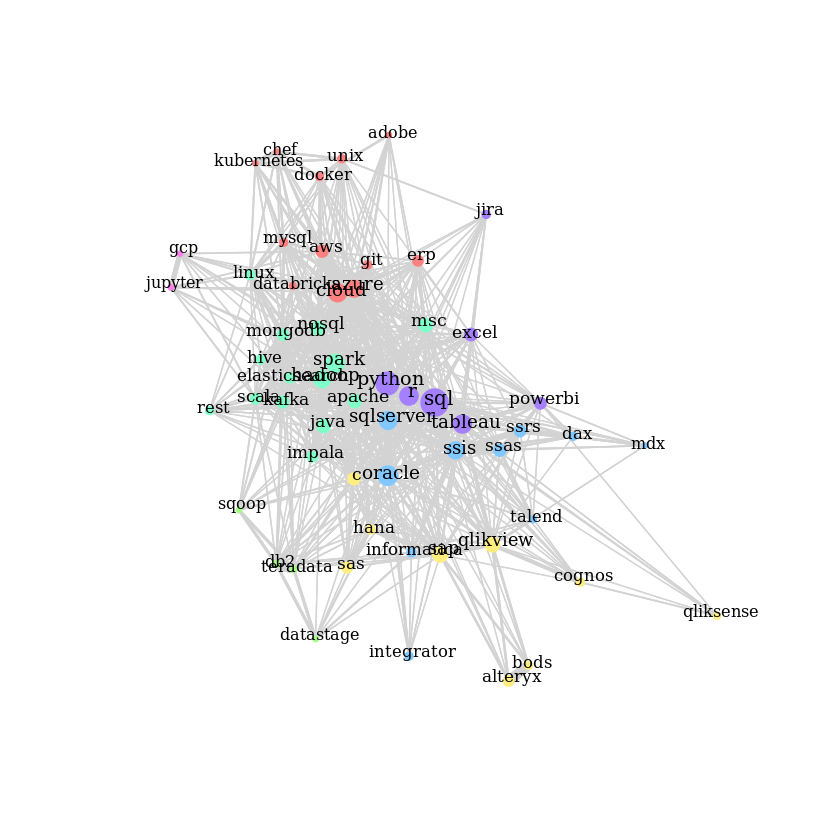

In [126]:
#The similarity measure. Currently supports: "con_prob" (conditional probability), "con_prob_weighted", "cosine" similarity, 
#"count_directed" (i.e number of cooccurrences) and "count_undirected" (same as count_directed, but returned as an 
#undirected network, chi2 (chi-square score))
#Co-occurence is calcuated based on how often two tokens occured within the same document


# node size denotes  the relative term frequency
# colour creates clusters of terms that frequenty appear together
# edges denote cooccurence of terms
# distance denotes the magnitude of association

g = semnet(subset(tc,!is.na(code_id)), 'feature', context_level='document', measure = 'chi2')
#g = semnet(subset(tc,!is.na(code_id)), 'feature', context_level='document', measure = 'con_prob')
#g = semnet(subset(tc,!is.na(code_id)), 'feature', context_level='document', measure = 'con_prob_weighted')
#g = semnet(subset(tc,!is.na(code_id)), 'feature', context_level='document', measure = 'cosine')
#g = semnet(subset(tc,!is.na(code_id)), 'feature', context_level='document', measure = 'count_directed')
plot_semnet (g)



Another interesting approach is to check the relationships towards a specific term. Eg. only keep nodes directly connected to a given node and create a graph.
In addition we can also see the node relationships, along with their weight (eg. edge width), in a table form.

In the following example we check the network of nodes directly connected to "alteryx"

,from,to,weight
,<chr>,<chr>,<dbl>
1,alteryx,bods,0.80000000
2,alteryx,cloud,0.11180340
3,bods,cloud,0.05590170
4,alteryx,qlikview,0.83045480
5,bods,qlikview,0.66436384
6,cloud,qlikview,0.09284767
7,alteryx,sap,0.37300192
8,bods,sap,0.46625240
9,cloud,sap,0.10425721


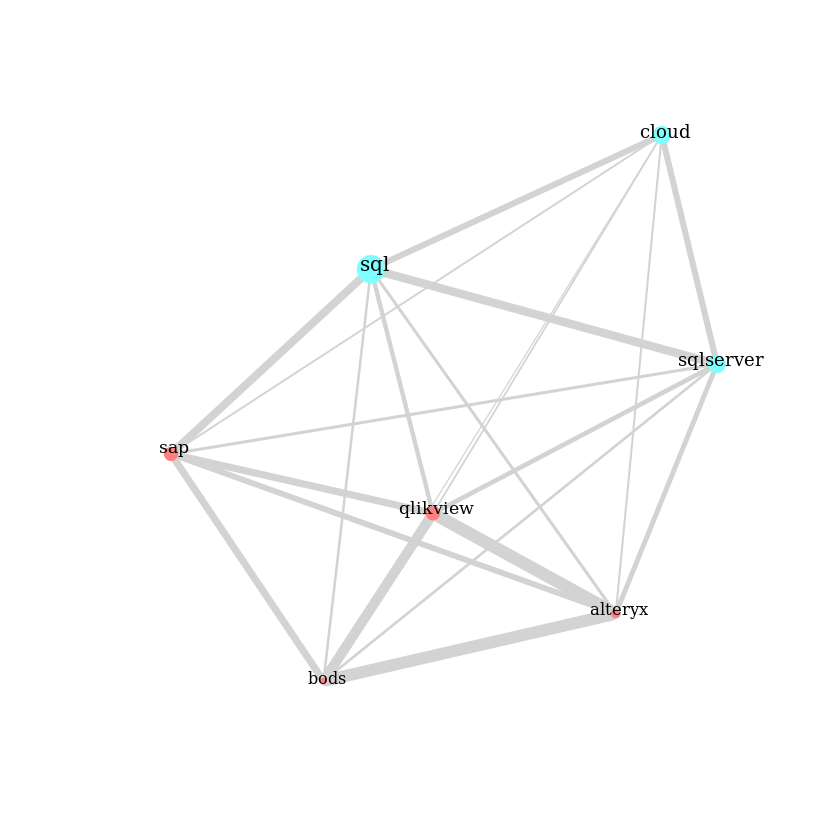

In [127]:
## only keep nodes directly connected to given node

tc2=subset(tc,!is.na(code_id))
g = tc2$semnet('feature')

g_ego = ego_semnet(g, 'alteryx')
igraph::get.data.frame(g_ego)
plot_semnet(g_ego)



We can compare feature frequencies between subsets of a corpus (compare_subset).
The output comp is a data.frame with for each feature how often it occured in the subset ("Business Intelligence") and the rest of the corpus ("Analytics").

For a quick peek, we can plot the most strongly overrepresented (ratio > 1) and underrepresented (ratio < 1). By default, the plot method for the output of a vocabulary comparison function(such as compare_subset) plots the log ratio on the x axis, and uses the chi2 score to determine the size of words (chi2 can be larger for more frequent terms, but also relies on how strongly a term is over/under-represented).

When applying this function in the "Business Intelligence" subset, we can see that the tools most in demand are

- oracle
- ssis
- sqlserver
- informatica
- sql
- tableau etc

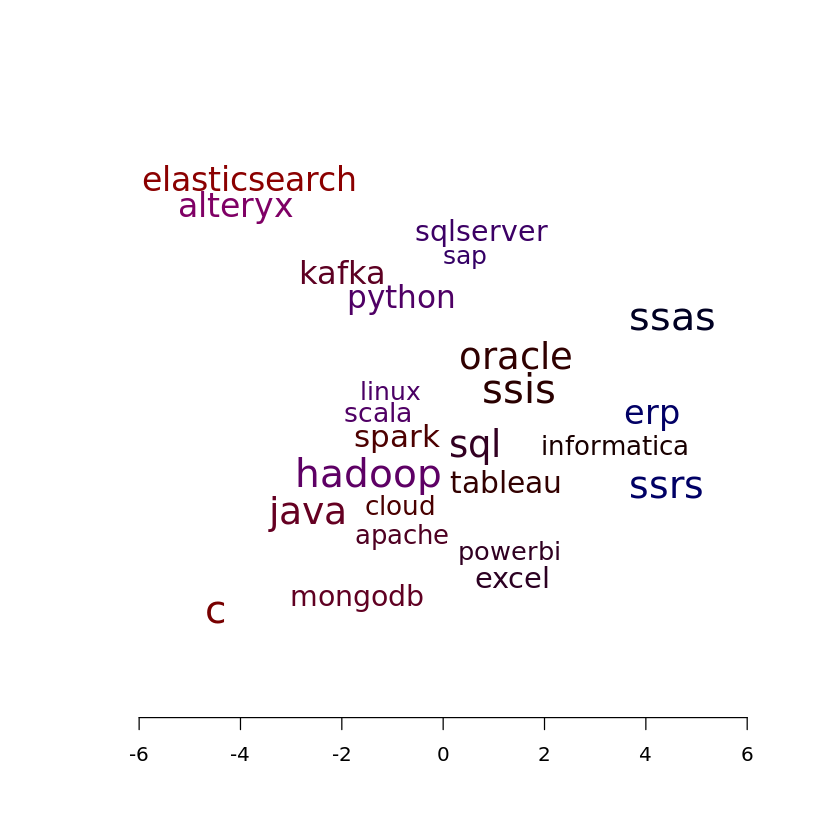

In [128]:
comp = compare_subset(tc2, feature='feature',
                      subset_meta_x = SearchTerms == "business intelligence")
plot(comp)


Similarly we perform the same function on "Analytics" and see the results on that subset vs the rest of the corpus.

In the "Analytics" subset, we can see that tools mostly in demand are:

- kafka
- hadoop
- cloud
- c
- elastisearch
- alteryx etc

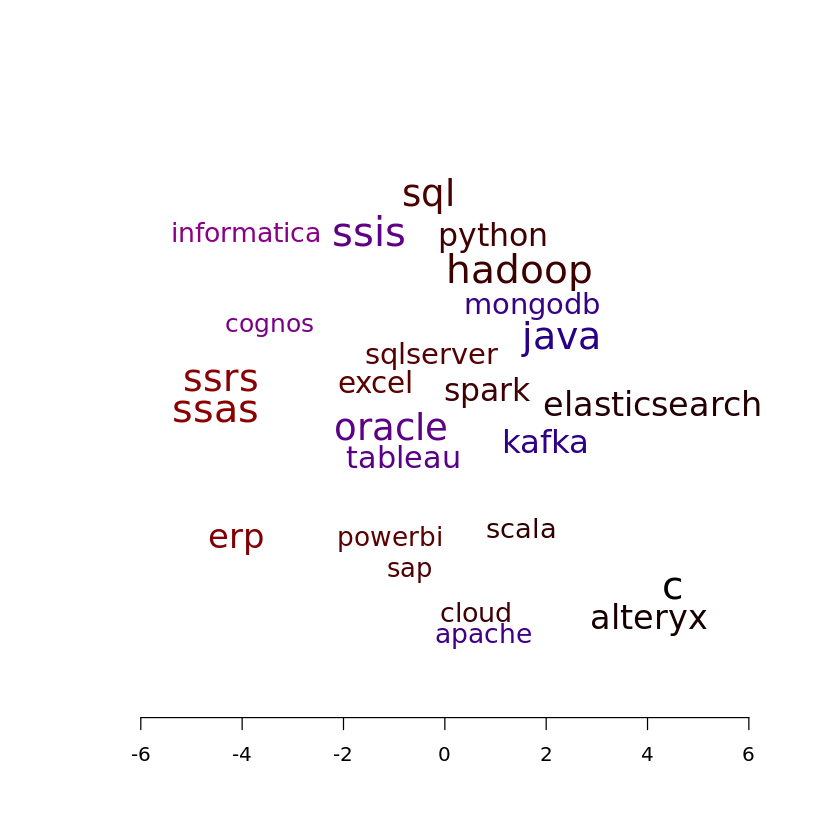

In [129]:
comp = compare_subset(tc2, feature='feature',
                      subset_meta_x = SearchTerms == "Analytics")
plot(comp)


# Soft Skills analysis

In a similar way, we can extract features related to "Soft skills" that are in demand by the employers.
By using a dictionary of "Soft skills", we are performing part of the analysis.

We create a frequency graph and the results are the following:

Preparing features
Preparing dictionary
Coding features
Preparing features
Preparing dictionary
Coding features


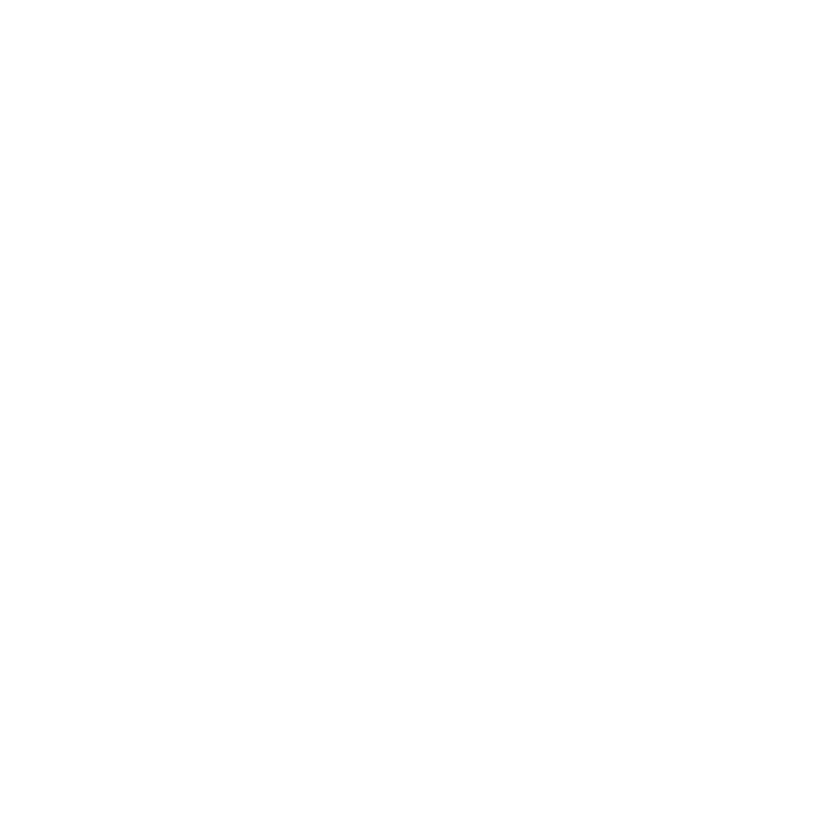

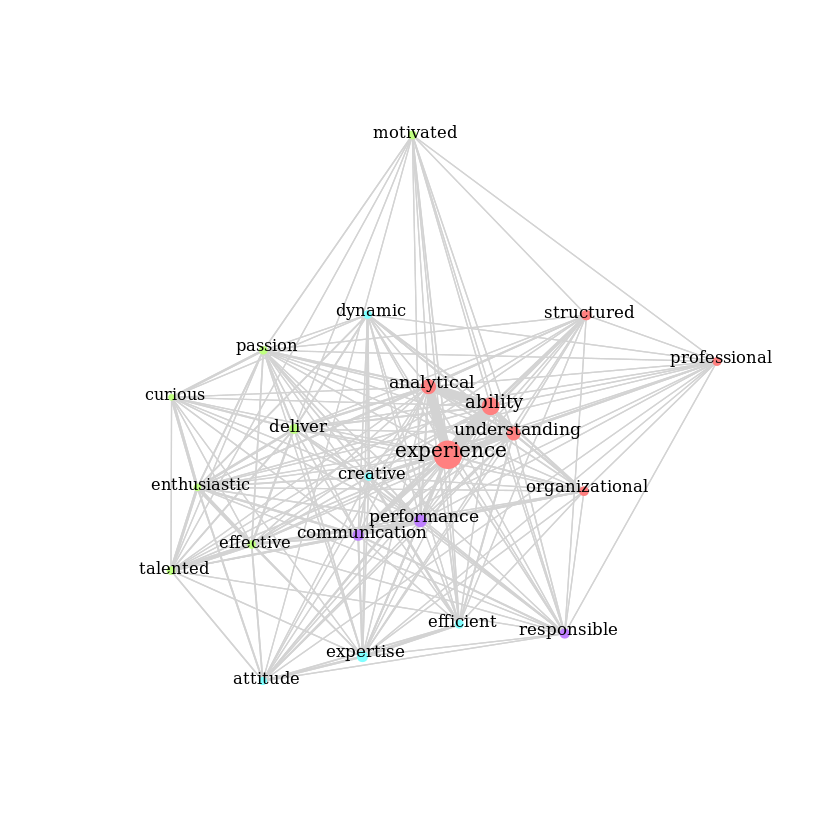

In [164]:

#create a list of softskills, from an external file
ss_list <- scan("data/samples/mine/soft_skills.txt", what="", sep="\n",skip = 1)

#create a "mapping" soft skills dictionary
soft_dict <- read.delim("data/samples/mine/soft_dict.txt")


#create corpus for vacancies
tc_s = create_tcorpus(VACANCIES, doc_column = 'JOBID', text_columns = 'REQUIREMENTS')

tc_s$preprocess(remove_stopwords=T, remove_numbers = T, ngrams=1, ngram_context = 'document', min_freq = 1)

#map terms according to dictionary file
tc_s$replace_dictionary(soft_dict, string_col='string',token_col='feature',code_col='code',sep=" ",verbose=T)

ss_df<-as.data.frame(ss_list)
colnames(ss_df)<-c("string")

tc_s$code_dictionary(ss_df,token_col = 'token', string_col = 'string',flatten_colloc=T, sep=" ",verbose=T)

g = semnet(subset(tc_s,!is.na(code_id)), 'feature', context_level='document', measure = 'chi2')
plot_semnet (g,reduce_labeloverlap=T)

